# FBXO11
[Intellectual developmental disorder with dysmorphic facies and behavioral abnormalities (IDDFBA)](https://omim.org/entry/618089) is caused by heterozygous mutation in the [FBXO11 gene](https://omim.org/entry/607871).

F-box proteins, such as FBXO11, contain an approximately 40-amino acid motif, the F box, that binds SKP1

import genophenocorr

In [1]:
import gpsea
from gpsea.analysis import configure_cohort_analysis, CohortAnalysisConfiguration
from gpsea.analysis.predicate import PatientCategories
from gpsea.preprocessing import load_phenopackets
from gpsea.preprocessing import configure_caching_cohort_creator
from gpsea.model import FeatureType, VariantEffect
from gpsea.view import CohortViewable
from gpsea.preprocessing import UniprotProteinMetadataService
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import VVMultiCoordinateService
from gpsea.view import ProteinVisualizable, ProteinVisualizer, ProteinViewable
import hpotk
from IPython.display import display, HTML

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.2.1.dev0


In [2]:
from ppktstore.registry import configure_phenopacket_registry
registry = configure_phenopacket_registry()
with registry.open_phenopacket_store(release="0.1.19") as ps:
  phenopackets = list(ps.iter_cohort_phenopackets("FBXO11"))
print(f"Found cohort with {len(phenopackets)} phenopackets for FBXO11")

Found cohort with 20 phenopackets for FBXO11


In [4]:
FBXO11_MANE_transcript = 'NM_001190274.2'
FBXO11_protein_id = 'NP_001177203.1' # F-box only protein 11 isoform 4
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets
cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)


Patients Created: 100%|██████████| 20/20 [00:02<00:00,  9.22it/s]


In [5]:
validation.summarize()  

Validated under none policy
No errors or warnings were found


In [9]:
cv = CohortViewable(hpo=hpo)
report = cv.process(cohort=cohort, transcript_id=FBXO11_MANE_transcript)
display(HTML(report))

HPO Term,ID,Seen in n individuals
Global developmental delay,HP:0001263,20
Intellectual disability,HP:0001249,20
Delayed speech and language development,HP:0000750,18
Delayed ability to walk,HP:0031936,11
Hypotonia,HP:0001252,9
Autistic behavior,HP:0000729,8
Strabismus,HP:0000486,8
Sleep onset insomnia,HP:0031354,6
Seizure,HP:0001250,6
Downslanted palpebral fissures,HP:0000494,5


In [10]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_protein_metadata_service, VVMultiCoordinateService
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_protein_metadata_service()
tx_coordinates = txc_service.fetch(FBXO11_MANE_transcript)
protein_meta = pms.annotate(FBXO11_protein_id)

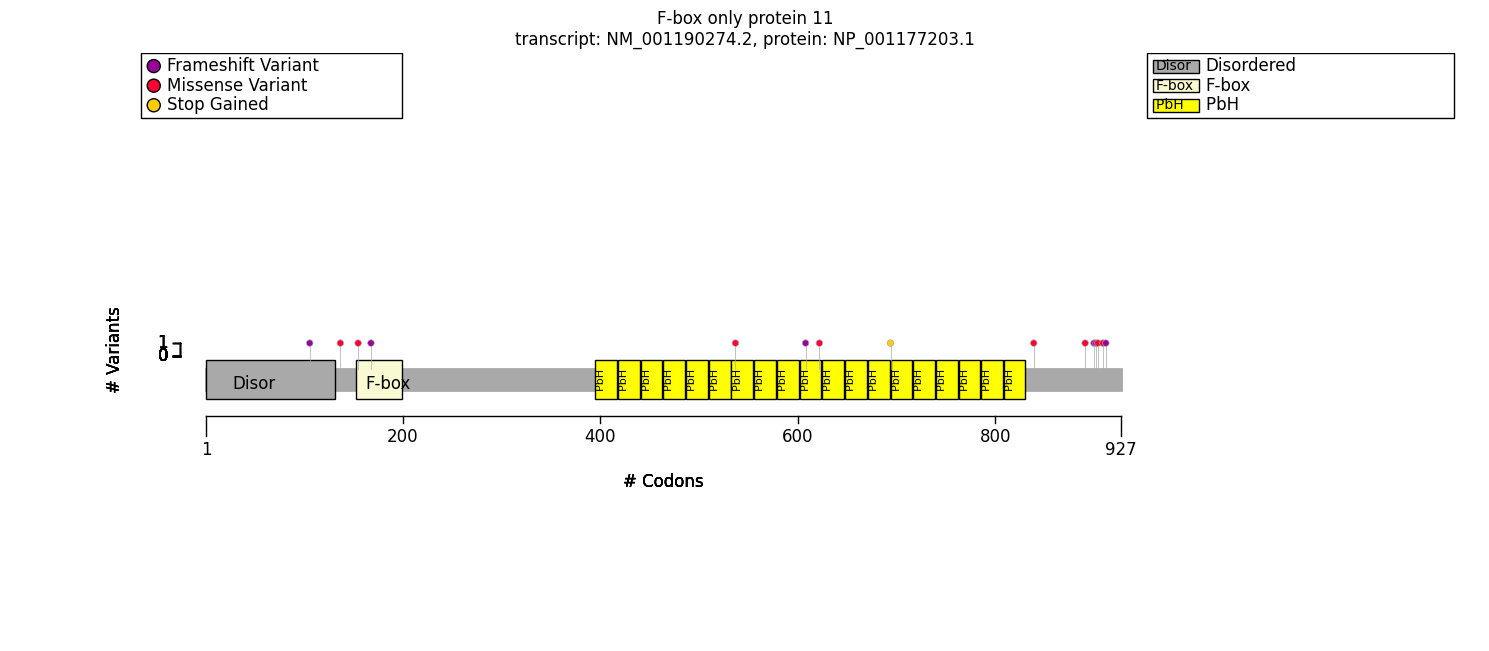

In [11]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fig.tight_layout()
#fig.savefig('docs/img/tutorial/tbx5_protein_diagram.png')  #

In [15]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, groups_predicate
gt_predicate = groups_predicate(
    predicates=(
        VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, FBXO11_MANE_transcript),
        VariantPredicates.variant_effect(VariantEffect.FRAMESHIFT_VARIANT, FBXO11_MANE_transcript)
    ),
    group_names=('Missense', 'Frameshift'),
)
gt_predicate.get_question()


'Genotype group: Missense, Frameshift'

In [16]:
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
    min_n_of_patients_with_term=2,
)

In [17]:
from gpsea.analysis.mtc_filter import HpoMtcFilter
mtc_filter = HpoMtcFilter.default_filter(hpo, term_frequency_threshold=0.2)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05

In [18]:
from gpsea.analysis.pcats.stats import ScipyFisherExact
count_statistic = ScipyFisherExact()

In [20]:
from gpsea.analysis.pcats import HpoTermAnalysis
analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=mtc_alpha,
)
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
result.total_tests


17

In [22]:
from gpsea.view import MtcStatsViewer
mtc_viewer = MtcStatsViewer()
mtc_report = mtc_viewer.process(result)
display(HTML(mtc_report))

Code,Reason,Count
TODO,Skipping term with maximum frequency that was less than threshold 0.2,83
TODO,Skipping general term,54
TODO,Skipping term because all genotypes have same HPO observed proportions,28
TODO,Skipping term with only 3 observations (not powered for 2x2),20
TODO,Skipping term with only 1 observations (not powered for 2x2),19
TODO,Skipping term with only 2 observations (not powered for 2x2),19
TODO,Skipping term with only 4 observations (not powered for 2x2),12
TODO,Skipping term with only 5 observations (not powered for 2x2),10
TODO,Skipping term with only 6 observations (not powered for 2x2),1


In [24]:
from gpsea.analysis.predicate import PatientCategories
summary_df = result.summarize(hpo, PatientCategories.YES)
summary_df

Genotype group: Missense, Frameshift Missense         Frameshift          \
                                        Count Percent      Count Percent   
Recurrent otitis media [HP:0000403]       0/8      0%        3/7     43%   
Seizure [HP:0001250]                      5/8     62%        1/7     14%   
Sparse eyebrow [HP:0045075]               0/8      0%        2/7     29%   
Autistic behavior [HP:0000729]            5/8     62%        2/7     29%   
Joint hypermobility [HP:0001382]          2/8     25%        0/7      0%   
...                                       ...     ...        ...     ...   
Atrial septal defect [HP:0001631]         1/8     12%        0/7      0%   
Smooth philtrum [HP:0000319]              0/8      0%        0/7      0%   
Frontal upsweep of hair [HP:0002236]      0/8      0%        0/7      0%   
Toe syndactyly [HP:0001770]               0/8      0%        0/7      0%   
Hirsutism [HP:0001007]                    0/8      0%        0/7      0%   

Genotype group: Missense, Frameshift                               
                                     Corrected p values  p values  
Recurrent otitis media [HP:0000403]            0.861888  0.076923  
Seizure [HP:0001250]                           0.861888  0.118881  
Sparse eyebrow [HP:0045075]                    0.861888  0.200000  
Autistic behavior [HP:0000729]                 0.861888  0.314685  
Joint hypermobility [HP:0001382]               0.861888  0.466667  
...                                                 ...       ...  
Atrial septal defect [HP:0001631]                   NaN       NaN  
Smooth philtrum [HP:0000319]                        NaN       NaN  
Frontal upsweep of hair [HP:0002236]                NaN       NaN  
Toe syndactyly [HP:0001770]                         NaN       NaN  
Hirsutism [HP:0001007]                              NaN       NaN  

[263 rows x 6 columns]